In [17]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 

import matplotlib.pyplot as plt 
import seaborn as sns

import tqdm 

torch.manual_seed(1)
np.random.seed(1)

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [18]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [19]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

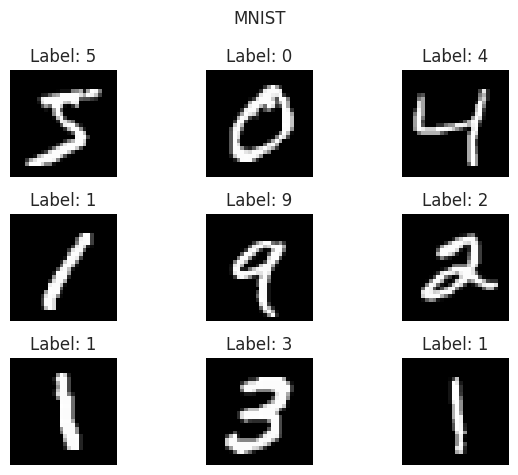

In [20]:
display_nine_images(mnist_trainset)

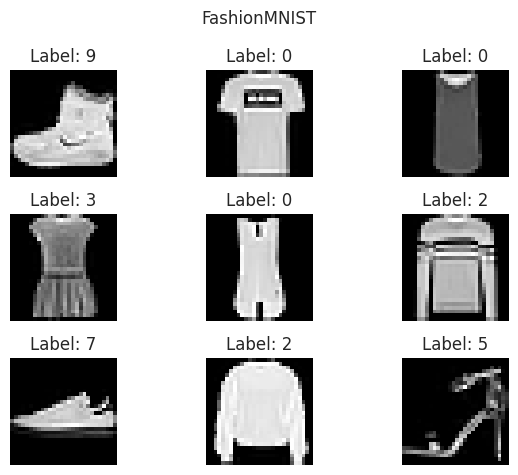

In [21]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [22]:
# implement k-means

def kmeans(X, K, max_iters=100, init='random'):
    N, D = X.shape 
    centroids = torch.zeros(K, D)
    if init == 'random':
        centroids = X[torch.randint(N, (K,))]
    elif init == 'kmeans++':
        centroids[0] = X[torch.randint(N, (1,))]
        for k in range(1, K):
            dists = torch.cdist(X, centroids[:k]).min(dim=1).values
            probs = dists / dists.sum()
            centroids[k] = X[torch.multinomial(probs, 1)]
    elif init == 'mean':
        for k in range(K):
            centroids[k] = X[(y == k).nonzero().squeeze()].mean(dim=0)
    else:
        raise ValueError('Invalid initialization')
    for _ in range(max_iters):
        dists = torch.cdist(X, centroids)
        labels = dists.argmin(dim=1)
        for k in range(K):
            centroids[k] = X[labels == k].mean(dim=0)
    return centroids, labels


In [23]:
# prepare data
X = mnist_trainset.data.view(-1, 28*28).float()
y = mnist_trainset.targets

# run k-means
K = 10

centroids, labels = kmeans(X, K, init='mean')

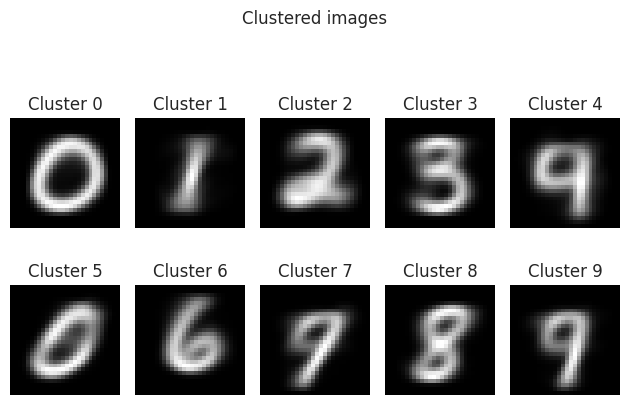

In [24]:
# plot clusters

def plot_clusters(X, labels, centroids):
    for k in range(K):
        plt.subplot(2, 5, k + 1) 
        plt.imshow(centroids[k].view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Cluster {k}')
    plt.suptitle('Centroids')
    plt.tight_layout()  

    for i in range(10):
        plt.subplot(2, 5, i + 1) 
        plt.imshow(X[labels == i].mean(dim=0).view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Cluster {i}')
    plt.suptitle('Clustered images')
    plt.tight_layout()
    
plot_clusters(X, labels, centroids)

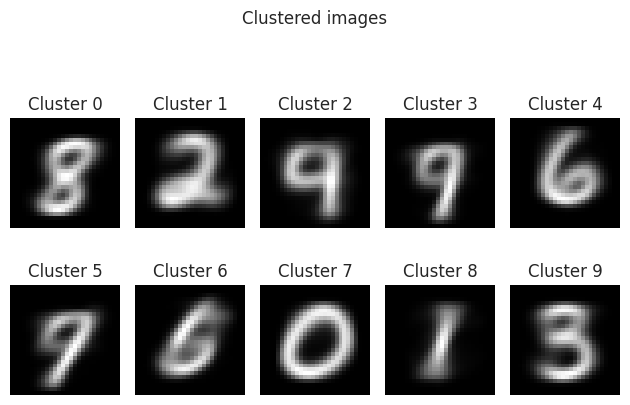

In [25]:
# run k-means with random initialization
centroids_rand, labels_rand = kmeans(X, K, init='random')
plot_clusters(X, labels_rand, centroids_rand)


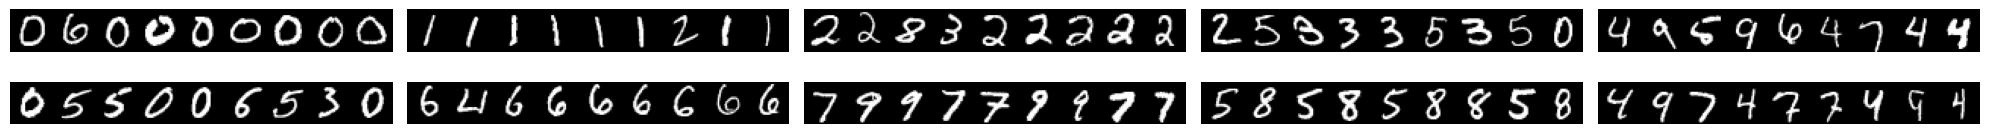

In [26]:
# classify test set
X_test = mnist_testset.data.view(-1, 28*28).float()
y_test = mnist_testset.targets

dists = torch.cdist(X_test, centroids)

labels_test = dists.argmin(dim=1)

# for each cluster, plot 9 images from the test set
# so it should be a 2x5 grid, each with a futher 3x3 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 2))  # Create a 2x5 grid of Axes

for k in range(K):
    images = []
    for i, idx in enumerate((labels_test == k).nonzero().squeeze()[:9]):
        images.append(X_test[idx].view(28, 28))
    # Concatenate the images to form a single image
    image = torch.cat(images, dim=1)
    axs[k // 5, k % 5].imshow(image, cmap='gray')
    axs[k // 5, k % 5].axis('off')

plt.tight_layout()
plt.show()
    



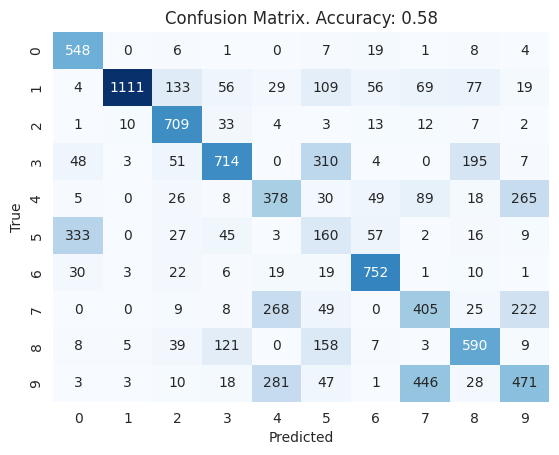

In [27]:
confusion_matrix = np.zeros((10, 10))
y_test = mnist_testset.targets  # Use the correct set of labels

for i in range(10):
    for j in range(10):
        confusion_matrix[i, j] = torch.sum((labels_test == i) & (y_test == j))

sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
# calculate accuracy and put it in the title
accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
plt.title(f'Confusion Matrix. Accuracy: {accuracy:.2f}')
plt.show()


Como podemos ver, o modelo erra bastante em alguns dígitos, e como podemos ver plotando os centróides, os números com pior performance são com os centroides que não se assemelham ao dígito que deveriam representar.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente: 
- (a) treine um MLP para classificar o MNIST;
- (b) com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino);
- (c) avalie a capacidade dessa GMM em diferenciar amostras de teste do MNIST e do FashionMNIST (espera-se que amostras OOD --- do FashionMNIST--- estejam nas caudas);
- (d) teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. 

Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [28]:
# train MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

train_loader = DataLoader(mnist_trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=32, shuffle=False)

for epoch in range(5):
    mlp.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat = mlp(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1} Loss: {loss.item()}')
    

Epoch 1 Loss: 0.14275921881198883
Epoch 2 Loss: 0.19417981803417206
Epoch 3 Loss: 0.25905168056488037
Epoch 4 Loss: 0.09742312878370285
Epoch 5 Loss: 0.11482807248830795


In [29]:
# get activations
mlp.eval()
activations = []
for x, y in train_loader:
    activations.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations = np.concatenate(activations)

# fit GMM
gmm = GaussianMixture(n_components=10)
gmm.fit(activations)


GaussianMixture(n_components=10)

In [41]:
# evaluate GMM
activations_test = []
for x, y in test_loader:
    activations_test.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations_test = np.concatenate(activations_test)

activations_test_fashion = []
for x, y in DataLoader(fashion_mnist_trainset, batch_size=32, shuffle=False):
    activations_test_fashion.append(mlp.fc1(x.view(-1, 28*28)).detach().numpy())
activations_test_fashion = np.concatenate(activations_test_fashion)

log_probs = gmm.score_samples(activations_test)
log_probs_fashion = gmm.score_samples(activations_test_fashion)
log_probs_train = gmm.score_samples(activations)

threshold_lower = np.percentile(log_probs_train, 5)
threshold_upper = np.percentile(log_probs_train, 95)
accuracy_mnist = np.mean((log_probs > threshold_lower) & (log_probs < threshold_upper))
ood_fashion = np.mean((log_probs_fashion < threshold_lower) | (log_probs_fashion > threshold_upper))
ood_mnist = np.mean((log_probs < threshold_lower) | (log_probs > threshold_upper))

print(f'MNIST Accuracy: {accuracy_mnist:.2f}')
print(f'MNIST OOD: {ood_mnist:.2f}')
print(f'FashionMNIST OOD: {ood_fashion:.2f}')

MNIST Accuracy: 0.89
MNIST OOD: 0.11
FashionMNIST OOD: 1.00


In [42]:
# test different number of components
n_components = [1, 2, 5, 10, 20]
results = []

for n in n_components:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(activations)
    
    log_probs = gmm.score_samples(activations_test)
    log_probs_fashion = gmm.score_samples(activations_test_fashion)
    log_probs_train = gmm.score_samples(activations)
    
    threshold_lower = np.percentile(log_probs_train, 5)
    threshold_upper = np.percentile(log_probs_train, 95)
    
    accuracy_mnist = np.mean((log_probs > threshold_lower) & (log_probs < threshold_upper))
    ood_fashion = np.mean((log_probs_fashion < threshold_lower) | (log_probs_fashion > threshold_upper))
    ood_mnist = np.mean((log_probs < threshold_lower) | (log_probs > threshold_upper))
    
    results.append((accuracy_mnist, ood_mnist, ood_fashion))
    
results = np.array(results)


Text(0.5, 1.0, 'GMM performance')

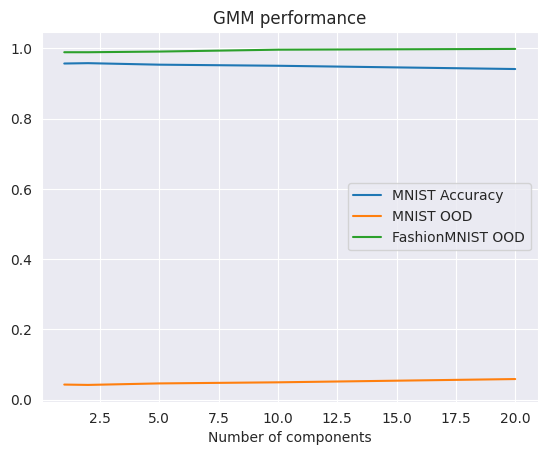

In [38]:
plt.plot(n_components, results[:, 0], label='MNIST Accuracy')
plt.plot(n_components, results[:, 1], label='MNIST OOD')
plt.plot(n_components, results[:, 2], label='FashionMNIST OOD')
plt.xlabel('Number of components')
plt.legend()
plt.title('GMM performance')

## Exercício de "papel e caneta"

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



**Resposta:**
Podemos reescrever a função custo como:
<br>
$
\begin{align}
&\sum_{i=1}^{K}\sum_{x \in C_i} \mathbb{E}_{x_{M(x)}\sim\mathcal{N}(0, cI_{|M(x)|})}[(x-\mu_i)^T(x-\mu_i)]=\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \mathbb{E}_{x_{M(x)}\sim\mathcal{N}(0, cI_{|M(x)|})}[\sum_{j=1}^{D}(x_j-\mu_{ij})^2]=\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \sum_{j=1}^{D}\mathbb{E}_{x_{M(x)}\sim\mathcal{N}(0, cI_{|M(x)|})}[(x_j-\mu_{ij})^2]
\end{align}
$
<br>
Para os valores observados, temos que $\mathbb{E}_{x_{M(x)}\sim\mathcal{N}(0, cI_{|M(x)|})}[(x_j-\mu_{ij})^2]=(x_j-\mu_{ij})^2$. Para os valores faltantes, temos que $x_{M(x)}\sim\mathcal N(0,cI_{|M_(x)|})$, então para cada $x_j\in M(x), x_j\sim\mathcal N(0,c)$.
$x_j-\mu_{ij}\sim\mathcal N(-\mu_ij,c)\implies \mathbb E((x_j-\mu_{ij})^2)=c+\mu_ij^2$, logo:
<br>
$
\begin{align}
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}\mathbb{E}_{x_j\sim\mathcal{N}(0, c)}[(x_j-\mu_{ij})^2] + \sum_{j\notin M(x)}[(x_j-\mu_{ij})^2]
\}=\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}[c + \mu_{ij}^2] + \sum_{j\notin M(x)}[(x_j-\mu_{ij})^2]
\}\\
\end{align}
$

Agora, derivamos a função custo em relação a $\mu_{i}$, para encontrar o valor ótimo dos centróides:
<br>
$
\begin{align}
&\frac{\partial}{\partial \mu_{i}}\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}[c + \mu_{ij}^2] + \sum_{j\notin M(x)}[(x_j-\mu_{ij})^2]
\}=\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}2\mu_{ij} + \sum_{j\notin M(x)}2(\mu_{ij}-x_j)
\}
\end{align}
$
<br>
Para encontrar o valor ótimo dos centróides, igualamos a derivada a zero e resolvemos para $\mu_{i}$:
<br>
$
\begin{align}
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}2\mu_{ij} + \sum_{j\notin M(x)}2(\mu_{ij}-x_j)
\}=0\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j\in M(x)}2\mu_{ij} + \sum_{j\notin M(x)}2\mu_{ij} - \sum_{j\notin M(x)}2x_j 
\}=0\\
&\sum_{i=1}^{K}\sum_{x \in C_i} \{\sum_{j=1}^D2\mu_{ij} - \sum_{j\notin M(x)}2x_j 
\}=0\\
\end{align}
$


**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 (página 430) do [_Pattern Recognition and Machine Learning_ (C. Bishop)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

Partimos, inicialmente, de uma sobreposição ponderada de gaussianas da forma:

$$
\begin{align}
p(\mathbf{x}) &= \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)\\
0 &\leq \pi_k \leq 1\\
&\sum_{k=1}^K \pi_k = 1
\end{align}
$$

Definimos a "responsabilidade" da gaussiana $k$ para a explicação do datapoint $n$ como:

$$
\gamma_{nk}=\dfrac{\pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}
$$

Para $N$ observações independentes, temos a log-likelihood:

$$
\begin{align}
log\ p(\mathbf{X}|\boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma}) &= \sum_{n=1}^Nlog\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)
\end{align}
$$

Supondo certas hipóteses de regularidade, podemos maximizar essa verossimilhança coordenada-a-coordenada (coordinate ascent), encontrando o ponto crítico do gradiente da log-likelihood com relação a cada parâmetro:

* Para cada $\boldsymbol{\mu}_k$:

$$
\begin{align}
\dfrac{\partial}{\partial \boldsymbol{\mu}_k}log\ p(\mathbf{X}|\boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma})&=0\\
\sum_{n=1}^N\dfrac{\partial}{\partial \boldsymbol{\mu}_k}log\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) &=0\\
\sum_{n=1}^N\dfrac{1}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\mu}_k}\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) &=0\\
\sum_{n=1}^N\dfrac{\pi_k}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\mu}_k} ((2\pi)^{-D/2}det(\Sigma_k)^{-1/2}exp(-\dfrac{1}{2}(x_n - \mu_k)^T\Sigma_k^{-1}(x_n - \mu_k))) &=0\\
\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\mu}_k} (-\dfrac{1}{2}(x_n - \mu_k)^T\Sigma_k^{-1}(x_n - \mu_k)) &=0\\
\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\mu}_k} (-\dfrac{1}{2}(x_n^T\Sigma_k^{-1}x_n - \mu_k^T\Sigma_k^{-1}x_n - x_n^T\Sigma_k^{-1}\mu_k + \mu_k^T\Sigma_k^{-1}\mu_k)) &=0\\
\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\Sigma^{-1}(x_n - \mu_k) &=0\\
\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}(x_n - \mu_k) &=0\\
\sum_{n=1}^N\gamma_{nk}(x_n - \mu_k) &=0\\
\sum_{n=1}^N\gamma_{nk}x_n =\sum_{n=1}^N\gamma_{nk}\mu_k\\
\sum_{n=1}^N\gamma_{nk}x_n =\mu_k\sum_{n=1}^N\gamma_{nk}\\
\dfrac{1}{\sum_{n=1}^N\gamma_{nk}}\sum_{n=1}^N\gamma_{nk}x_n =\mu_k\\
\end{align}
$$

Que nada mais é que uma média dos datapoints, ponderada pela responsabilidade do cluster de interesse em explicar cada datapoint.

* Para cada $\boldsymbol{\Sigma}_k$:

$$
\begin{align}
\dfrac{\partial}{\partial \boldsymbol{\Sigma}_k}log\ p(\mathbf{X}|\boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma})&=0\\
...\\
\sum_{n=1}^N\dfrac{\pi_k}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\Sigma}_k} (exp(-\dfrac{D}{2}log(2\pi) -\dfrac{1}{2} log\ det(\Sigma_k)^{-1/2}-\dfrac{1}{2}(x_n - \mu_k)^T\Sigma_k^{-1}(x_n - \mu_k))) &=0\\
-\dfrac{1}{2}\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\Sigma}_k} (D log(2\pi) + log\ det(\Sigma_k)^{-1/2}+(x_n - \mu_k)^T\Sigma_k^{-1}(x_n - \mu_k)) &=0\\
-\dfrac{1}{2}\sum_{n=1}^N\gamma_{nk}(\Sigma_k^{-1}-\Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^T\Sigma_k^{-1}) &=0\\
\sum_{n=1}^N\gamma_{nk}\Sigma_k^{-1} =\sum_{n=1}^N\gamma_{nk}\Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^T\Sigma_k^{-1}\\
\Sigma_k =\dfrac{1}{\sum_{n=1}^N\gamma_{nk}}\sum_{n=1}^N\gamma_{nk}(x_n - \mu_k)(x_n - \mu_k)^T\\
\end{align}
$$

Sendo que, no último passo, multiplicamos cada lado duas vezes por $\Sigma_k$. De modo análogo ao anterior, temos uma média ponderada das matrizes de covariância amostral.

* Para cada $\boldsymbol{\pi}_k$, é necessário assegurar a restrição, sendo preciso usar multiplicadores de Lagrange:

$$
\begin{align}
L(\pi_k, \lambda) = log\ p(\mathbf{X}|\boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma}) + \lambda (\sum_{k=1}^K \pi_k - 1)\\
\dfrac{\partial}{\partial \pi_k} L(\pi_k, \lambda) &=0\\
\sum_{n=1}^N\dfrac{1}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}\dfrac{\partial}{\partial \boldsymbol{\pi}_k}\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) +\lambda\dfrac{\partial}{\partial \boldsymbol{\pi}_k}  (\sum_{k=1}^K \pi_k - 1)&=0\\
\sum_{n=1}^N\dfrac{\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} +\lambda&=0\\
-\sum_{n=1}^N\dfrac{\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}(\pi_k) &=\lambda(\pi_k)\\
-\sum_{k=1}^K\sum_{n=1}^N\dfrac{\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}(\pi_k) &=\lambda\sum_{k=1}^K(\pi_k)\\

-N &=\lambda(1)\\
\end{align}
$$

Substituindo em (4)

$$
\sum_{n=1}^N\dfrac{\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} +(-N)=0\\
\sum_{n=1}^N\dfrac{\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}(\dfrac{\pi_k}{\pi_k}) =N\\

\sum_{n=1}^N\dfrac{\pi_k\mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_n} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} =N\pi_k\\
N_k=N\pi_k\\
\pi_k=\dfrac{N_k}{N}
$$

Ou seja, a proporção efetiva de datapoints atribuídos ao cluster $k$.

Após otimizar os hiperparâmetros em relação às atribuições de clusters, atualizamos as atribuições de clusters e repetimos o processo até convergência.